In [1]:
#Cargamos las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importamos la base
df = pd.read_csv("https://cdn.buenosaires.gob.ar/"+
                 "datosabiertos/datasets/"+
                 "direccion-general-de-estadisticas-y-censos/"+
                 "encuesta-anual-hogares/encuesta-anual-hogares-2019.csv",
                 encoding="latin1")

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14319 entries, 0 to 14318
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           14319 non-null  object 
 1   nhogar                       14319 non-null  object 
 2   miembro                      14319 non-null  object 
 3   comuna                       14319 non-null  object 
 4   edad                         14319 non-null  int64  
 5   parentesco_jefe              14319 non-null  object 
 6   situacion_conyugal           14318 non-null  object 
 7   num_miembro_padre            14319 non-null  object 
 8   num_miembro_madre            14319 non-null  object 
 9   estado_ocupacional           14319 non-null  object 
 10  cat_ocupacional              14319 non-null  object 
 11  calidad_ingresos_lab         14319 non-null  object 
 12  ingreso_total_lab            14319 non-null  int64  
 13  calidad_ingresos

Generamos las transformaciones hechas en anteriores desafíos

In [3]:
#Creamos el target para nivel_max_educativo
def target(row):  
    if (row['nivel_max_educativo'] == 'Secundario/medio comun') | (row['nivel_max_educativo'] == 'EGB (1° a 9° año)'):
        return 'sec_completo'
    elif (row['nivel_max_educativo'] == 'Primario especial') | (row['nivel_max_educativo'] == 'Primario comun'):
        return 'prim_completo'
    elif row['nivel_max_educativo'] == 'Sala de 5':
        return 'inicial'
    elif row['nivel_max_educativo'] == 'Otras escuelas especiales':
        return 'superior'
    elif (row["nivel_max_educativo"] == "nan"):
      return "nan"

df['Target'] = df.apply(lambda row: target(row), axis=1)

#Remplazo los valores para que todos sean numéricos
df.loc[df.años_escolaridad=="Ningun año de escolaridad aprobado","años_escolaridad"]=0
df["años_escolaridad"] = df["años_escolaridad"].astype('float')

#Hay determinadas variables (comuna,id,nhogar y miembro) que están como numéricas pero deberían ser categóricas.
df[["comuna","id","nhogar","miembro"]] = df[["comuna","id","nhogar","miembro"]].applymap(str)

#Por otro lado, variables como sexo y dominio pueden pasarse a numérico mediante one hot encoding.

#one hot encoding
df = pd.get_dummies(df, columns=['sexo','dominio'],drop_first=True)

#me quedo con la variable target para armar gráficos más adelante
df["target"] = df["Target"]

# Paso la variable Target a one hot encoding
df = pd.get_dummies(df, columns=['Target'],drop_first=False,dummy_na=False)

#La variable "cantidad_hijos_nac_vivos" se puede pasar a numérica si se toma "no corresponde" como NAN.
df.loc[df.cantidad_hijos_nac_vivos=="No corresponde","cantidad_hijos_nac_vivos"]="0"
df["cantidad_hijos_nac_vivos"] = df["cantidad_hijos_nac_vivos"].apply(int)

# Por último renombramos algunas variables para que sean más cortas
df.rename(columns = {'dominio_Villas de emergencia': 'dominio_villas', 
                     'ingreso_per_capita_familiar': 'ing_per_cap_familiar',
                     "cantidad_hijos_nac_vivos" : "cant_hijos_nac_vivos"}, inplace = True)

Primero cruzamos todas las variables que nos interesan para ver si encontramos algún patrón interesante

Text(0.5, 1.01, 'Graficos de dispersion del Nivel Educativo alcanzado')

<Figure size 1152x720 with 0 Axes>

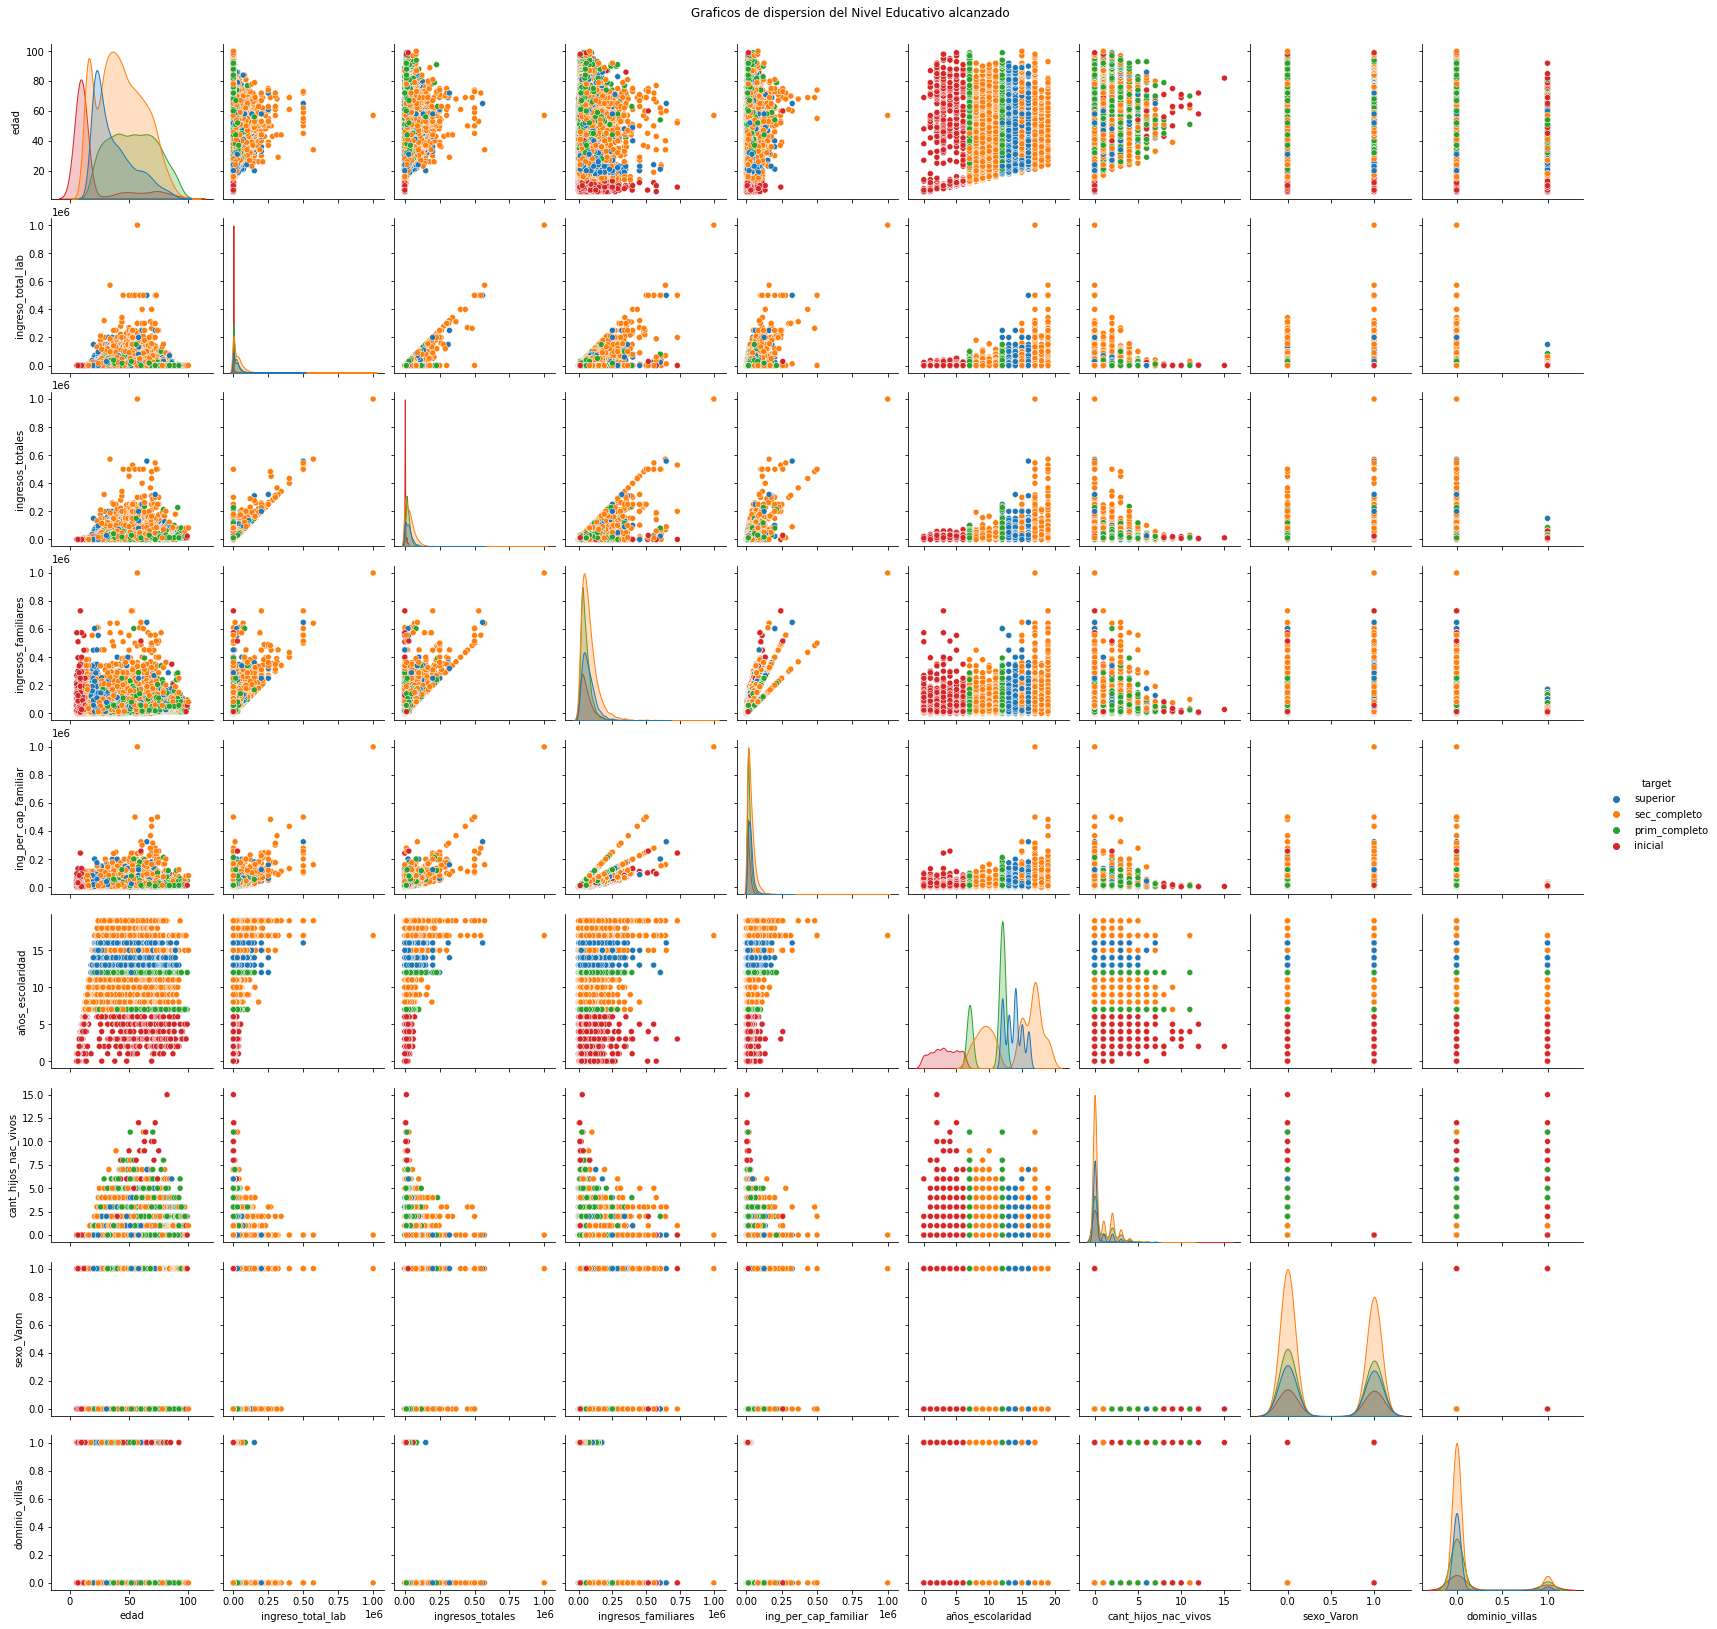

In [ ]:
#Hago un df nuevo para reducir la dimensionalidad con las variables que más nos interesan 
df1= df[['edad', 'ingreso_total_lab', 'ingresos_totales', 'ingresos_familiares',
         'comuna','ing_per_cap_familiar', 'años_escolaridad', 'cant_hijos_nac_vivos',
         'sexo_Varon', 'target', 'dominio_villas']]

#Grafico multivariado 1
plt.figure(figsize=(16, 10))
g = sns.pairplot(df1, hue='target')
g.fig.suptitle("Graficos de dispersion del Nivel Educativo alcanzado", y=1.01)

Probamos de cruzar años de escolaridad, nivel máximo educativo y los ingresos totales.

Text(0.5, 0.98, 'Años escolaridad e ingresos totales')

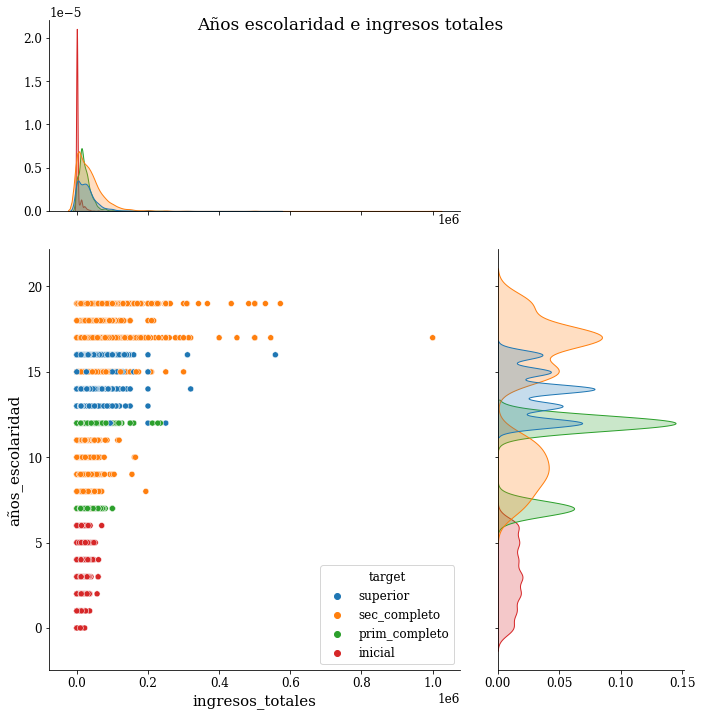

In [86]:
a=sns.jointplot(data=df, x="ingresos_totales", y="años_escolaridad", hue='target',   height=10, ratio=2, marginal_ticks=True)
a.fig.suptitle("Años escolaridad e ingresos totales", fontsize=17)

#b=sns.jointplot(data=df, x="ingresos_familiares", y="años_escolaridad", hue='target',   height=10, ratio=2, marginal_ticks=True)
#b.fig.suptitle("Años escolaridad e ingresos familiares", fontsize=17)

#c=sns.jointplot(data=df, x="ing_per_cap_familiar", y="años_escolaridad", hue='target',   height=10, ratio=2, marginal_ticks=True)
#c.fig.suptitle("Años escolaridad e ingresos familiares per cap", fontsize=17)

Conclusiones de la visualización:
* Hasta los 6 años, como era esperable, todos los casos llegan al nivel inicial
* Vemos dos años en que aparece el primario completo: 7 y 12 años. Estimamos que se debe a la división entre los que comenzaro su educación en la primaria y los que comenzaron en el nivel inicial.
* A partir de los 12 años vemos un aumento consistente de los ingresos totales

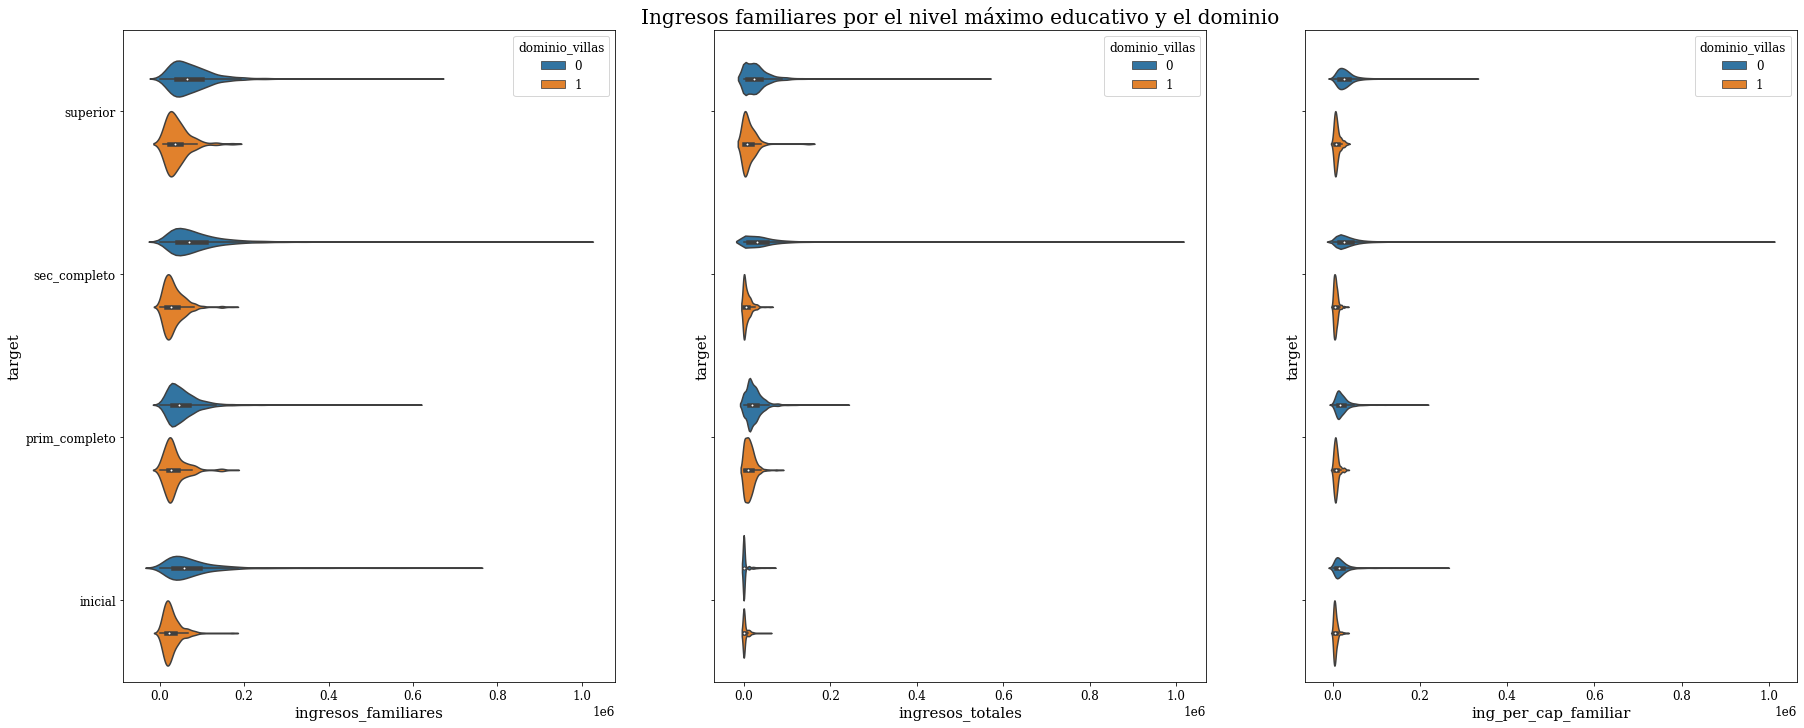

In [88]:
fig, ax = plt.subplots(figsize=(30,12),ncols=3,sharey=True)
sns.violinplot(data=df,x='ingresos_familiares',hue='dominio_villas',y='target',ax=ax[0])
sns.violinplot(data=df,x='ingresos_totales',hue='dominio_villas',y='target',ax=ax[1])
sns.violinplot(data=df,x='ing_per_cap_familiar',hue='dominio_villas',y='target',ax=ax[2])
ax[1].set_title("Ingresos familiares por el nivel máximo educativo y el dominio",size=20);

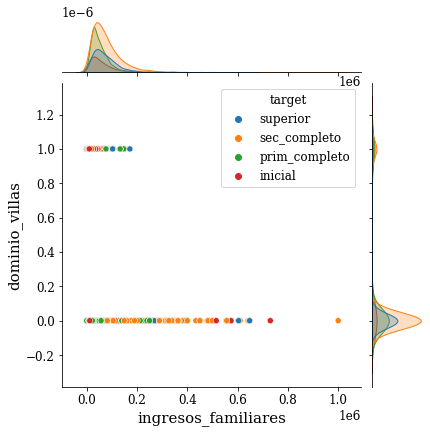

In [85]:
#sns.jointplot(data=df, x="ingresos_totales", y="dominio_villas", hue='target')
sns.jointplot(data=df, x="ingresos_familiares", y="dominio_villas", hue='target')
#sns.jointplot(data=df, x="ing_per_cap_familiar", y="dominio_villas", hue='target')

Aquí obtuvimos un descubrimiento interesante: no importa el nivel máximo educativo, los casos que no provienen de villas de emergencia (dominio_villas=0) obtienen en promedio valores más altos en todos los niveles educativos. El alcanzar estudios superiores no parece homogeneizar ambos conjuntos.

Ahora probaremos comparar ingresos familiares, nivel máximo educativo y comuna

In [ ]:
!pip install geopandas

In [91]:
import geopandas as gpd
#Vamos a generar un mapa, así que vamos a importar el mapa de comunas de la Ciudad de Buenos Aires
c = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson")

c["COMUNAS"] = c["COMUNAS"].str.replace(".00000000000","",regex=True)

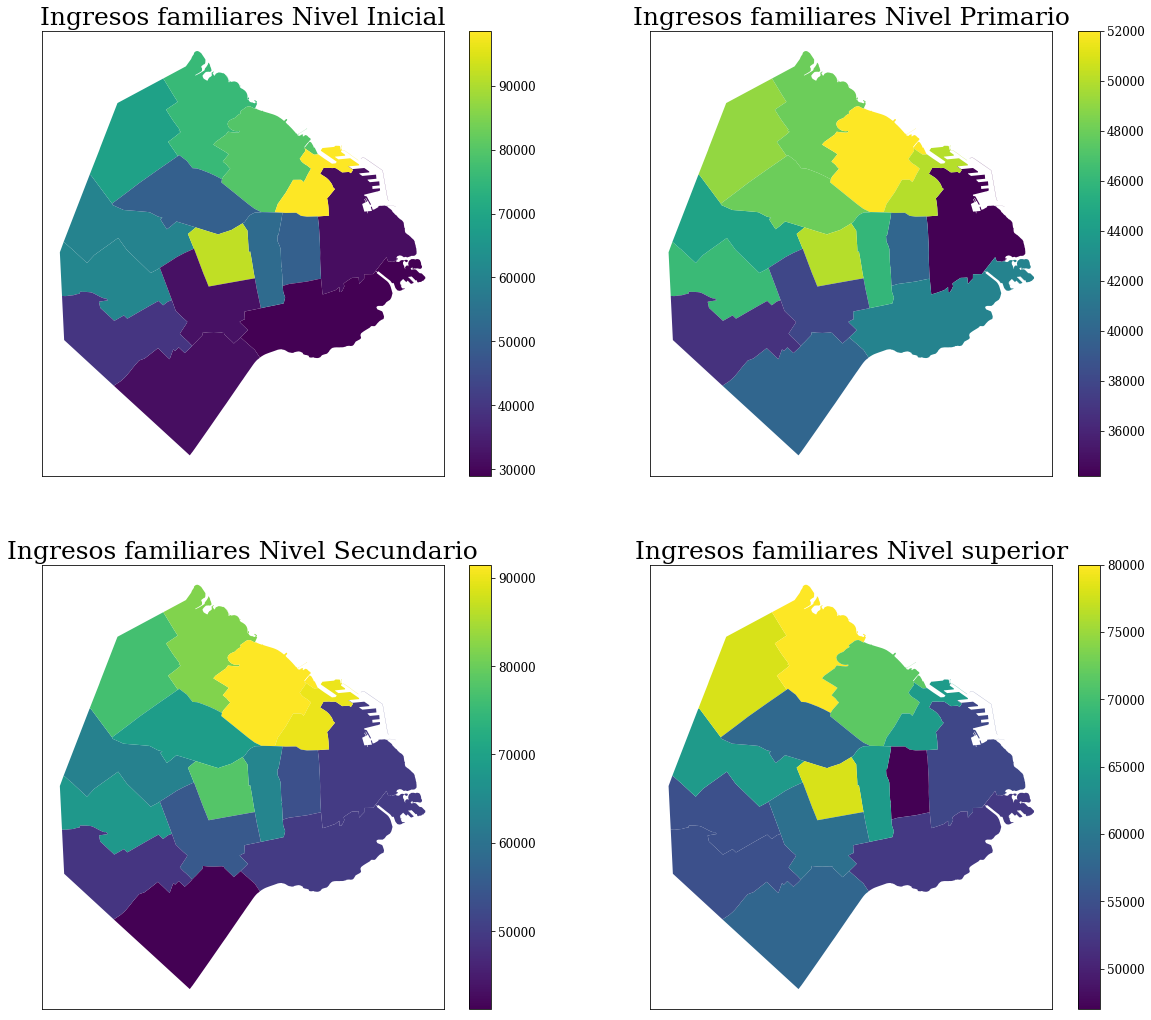

In [94]:
# Unimos ambos datasets
df2 = df.groupby(["comuna",'target']).agg({'ingresos_familiares':"median"}).reset_index() #Tomamos la mediana de los ingresos familiares

comunas = gpd.GeoDataFrame(pd.merge(df2,c[["COMUNAS","geometry"]],left_on="comuna",right_on="COMUNAS"))

#comunas.iloc[:,0:15] = comunas.iloc[:,0:15].applymap(int)

#generamos el lienzo
fig , ax = plt.subplots(figsize=(20,18),ncols=2,nrows=2,sharex=True,sharey=True)
plt.rcParams.update({"font.size":12,"axes.titlesize":25,"axes.labelsize":15, 'font.family':'serif'})

def mapa(variable,etiqueta,fila,columna):
  #mapa
  comunas[comunas['target']==variable].plot(column='ingresos_familiares',
                                            legend=True,cmap="viridis",legend_kwds={'label': ""},ax=ax[fila,columna])

  #Título y etiquetas de variables    
  ax[fila,columna].set_title('Ingresos familiares ' + etiqueta)
  ax[fila,columna].get_xaxis().set_visible(False)
  ax[fila,columna].get_yaxis().set_visible(False);

mapa("superior","Nivel superior",1,1)
mapa("sec_completo","Nivel Secundario",1,0)
mapa("prim_completo","Nivel Primario",0,1)
mapa("inicial","Nivel Inicial",0,0)

No encontré la forma de poner un título general al gráfico. Queda pendiente para mejorar en futuras entregas.

Aquí podemos observar que a medida que avanza el nivel educativo máximo se atenúan levemente las diferencias de ingresos familiares entre comunas. Queda pendiente cruzar estos datos con la edad, para saber si el hecho de incluir a menores de edad está sesgando los valores para nivel inicial, primario y secundario.